In [1]:
import sys
import os

# Get the current working directory (where the notebook is located)
curr_dir = os.getcwd()

# Add the project root to the system path
project_root = os.path.abspath(os.path.join(curr_dir, '..', '..'))
sys.path.append(project_root)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
from src.LoadEcoCounterData import EcoCounterData as BikeData
from src.LoadWeatherData import WeatherCounterData as WeatherData
from src.LoadEventsData import EventsData

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tueplots import bundles
from tueplots import bundles
import src.Colortheme as ct
import src.EventsDataPlotter as EPlot
import src.BikeDataPlotter as BPlot

import matplotlib.dates as mdates
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# Paper Figure: Example Year Showcasing Trends

In [2]:
bd = BikeData()
wd = WeatherData()
ed = EventsData()

df = bd.get_daily_data(counter_id=[100003359]) # Use Steinlachallee as example counter

decomposition_365 = seasonal_decompose(df['zählstand'], model='additive', period=365, two_sided=False)
decomposition_7 = seasonal_decompose(df['zählstand'], model='additive', period=7, two_sided=False)

In [3]:
weather_df = wd.get_df([2022, 2023], to_local_time=True) # import all year data with local timezone
# weather_df = weather_df[(weather_df["iso_timestamp"].dt.hour >= 6) & (weather_df["iso_timestamp"].dt.hour <= 18)]
my_weather_df = weather_df.groupby(weather_df["iso_timestamp"].dt.date)["temperature"].mean().reset_index() #.agg("mean", "sum").reset_index()
my_weather_df["precipitation"] = weather_df.groupby(weather_df["iso_timestamp"].dt.date)["precipitation"].sum().reset_index()["precipitation"]
my_weather_df["temp_smoothed"] = my_weather_df["temperature"].rolling(7).mean()
my_weather_df["iso_timestamp"] = pd.to_datetime(my_weather_df["iso_timestamp"])
my_weather_df = my_weather_df[my_weather_df["iso_timestamp"].dt.year == 2023].reset_index()

In [4]:
import importlib

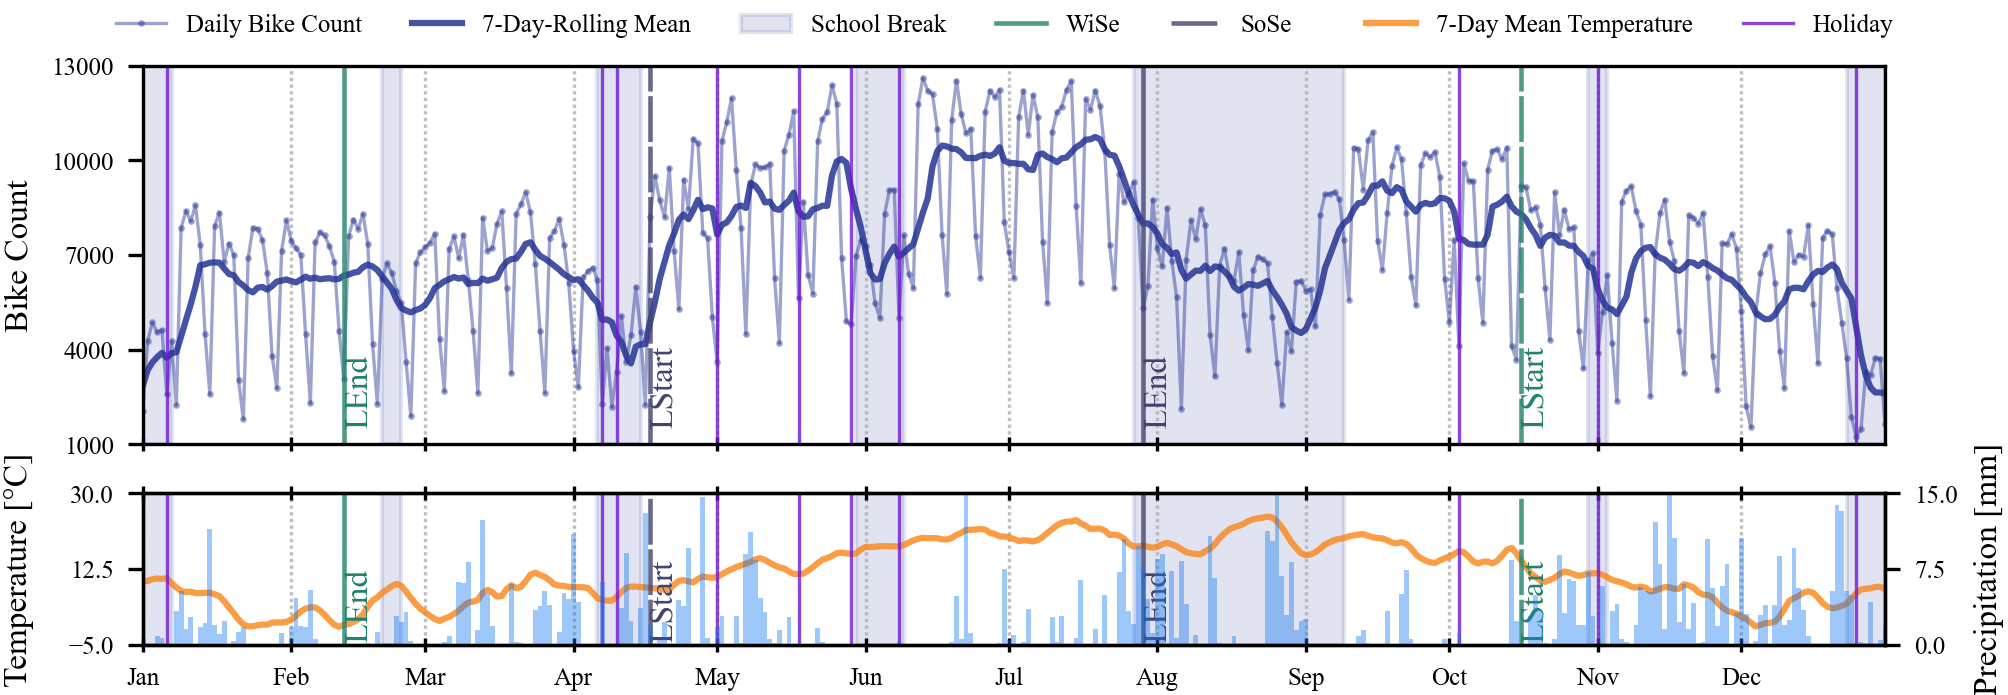

In [54]:
importlib.reload(ct)
importlib.reload(EPlot)
importlib.reload(BPlot)

# Adjusting plot parameters
plt.rcParams.update(bundles.icml2022(column="full", family="serif", usetex=False, nrows=2, ncols=3.8))
plt.rcParams.update({"figure.dpi": 300})
plt.rcParams['font.serif'] = "Times New Roman"

# Create a 2x1 grid with shared x-axis
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1]}, )
x_data = [df["iso_timestamp"], my_weather_df["iso_timestamp"]]
y_data = [
    [decomposition_7.observed, decomposition_7.trend],
    [my_weather_df["temp_smoothed"], my_weather_df["precipitation"]]
]
labels = [
    ["Daily Bike Count", "7-Day-Rolling Mean"],
    ["7-Day Mean Temperature", "Daily Precipitation"]
]
colors = [
    [BPlot.COUNT_STYLE["c"], BPlot.ROLLING_WINDOW_STYLE["c"]],
    [ct.TEMP_COLOR, ct.RAIN_COLOR]
]
markers = [
    [
        {"m": BPlot.COUNT_STYLE["m"], "ms": BPlot.COUNT_STYLE["ms"]},
        {"m": BPlot.ROLLING_WINDOW_STYLE["m"], "ms": BPlot.ROLLING_WINDOW_STYLE["ms"]}
    ],
    [{"m": "None", "ms": 2}]
]
lines = [
    [
        {"ls": BPlot.COUNT_STYLE["ls"], "lw": BPlot.COUNT_STYLE["lw"]},
        {"ls": BPlot.ROLLING_WINDOW_STYLE["ls"], "lw": BPlot.ROLLING_WINDOW_STYLE["lw"]}
    ],
    [{"ls": "-", "lw": BPlot.ROLLING_WINDOW_STYLE["lw"]}]
]
alpha = [
    [BPlot.COUNT_STYLE["a"], BPlot.ROLLING_WINDOW_STYLE["a"]],
    [.8, .4]
]

ax2 = axes[1].twinx()
unique_labels = set() 
for i, ax in enumerate(axes):
    for j in range(2):
        if i == 1 and j == 1:
            line = ax2.bar(
                x_data[i], y_data[i][j],
                color=colors[i][j],
                label=labels[i][j],
                width=1, alpha=alpha[i][j],
            )[0]
            unique_labels.add((line, labels[i][j])) 
        else:
            line = ax.plot(
                x_data[i], y_data[i][j],
                ls=lines[i][j]["ls"],
                lw=lines[i][j]["lw"],
                marker=markers[i][j]["m"], ms=markers[i][j]["ms"],
                color=colors[i][j],
                label=labels[i][j],
                alpha=alpha[i][j],
            )[0]
            unique_labels.add((line, labels[i][j])) 

    if i == 0:
        ax.set_ylim(1000, 13000)
        ax.set_yticks(np.linspace(1000, 13000, 5))
        ax.set_ylabel("Bike Count")
        ax.tick_params(axis='x', which='major', bottom=True, direction='inout')
        ax.tick_params(axis='x', which='both', bottom=True, direction='inout')
    else:
        ax.tick_params(axis='x', which='major', direction='inout', top=True)
        ax_ylim = [-5,30]
        ax.set_ylim(ax_ylim)
        ax2_ylim = [0,15]
        ax2.set_ylim(ax2_ylim)
        # ax.set_xlabel("Day")
        ax.set_ylabel("Temperature [°C]")
        ax2.set_ylabel("Precipitation [mm]")
        ax.set_yticks(np.linspace(ax_ylim[0], ax_ylim[1], 3))
        ax2.set_yticks(np.linspace(ax2_ylim[0], ax2_ylim[1], 3))

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(axis="x", which="major", ls=(5, (1, 1)), lw=0.8, alpha=0.8)
    ax.set_xlim(pd.Timestamp("2023-01-01"), pd.Timestamp("2023-12-31"))

holidays = EPlot.plot_holidays(ed, [2023], axes, duplicates=False)
EPlot.plot_school_breaks(ed, [2023], axes, duplicates=True)
EPlot.plot_lecture_period(ed, [2023], axes, duplicates=True)

# Extract unique labels and handles for both axes
h, l = axes[0].get_legend_handles_labels()
h1, l1 = axes[1].get_legend_handles_labels()

# Add labels and handles from the second axis to the first axis
# h.extend(h_cut)
# l.extend(l_cut)

# Create the final legend for the first axis
fig.legend(h, l, bbox_to_anchor=(0.05, 1.08), ncol=5, loc="upper left", frameon=False)

# Create the final legend for the second axis
fig.legend(h1[:2], l1[:2], bbox_to_anchor=(.95, 1.08), ncol=5, loc="upper right", frameon=False)
fig.align_labels()
# Display the plot
plt.savefig("fig_example_year.pdf")
